# Forecasting the energy performance of buildings : Python version

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## I. Exploration des données 

### I.1 Ouverture des données 

In [4]:
data = pd.read_csv('./DataEnergy-Students.csv')
data.rename(columns={"Load": "Energy"}, inplace = True)
data = data.reset_index(drop = True)
data['orientation'] = data['orientation'].astype('category')
data.head()

,Relative.compactness,Surface.area,Wall.area,Roof.area,Overall.height,orientation,Glazing.area,Glazing.area.distr,Energy,Energy.efficiency
0,0.982928,530.489958,306.484593,112.002683,7.0,North,0.016095,0,34.263943,C
1,0.983547,519.872380,299.776324,110.048028,7.0,East,-0.009387,0,34.589751,C
2,0.979453,516.191221,303.374358,106.408431,7.0,South,-0.000697,0,38.778048,C
3,0.977733,518.924089,292.812213,113.055938,7.0,West,0.000010,0,37.947808,C
4,0.903029,552.968920,316.236102,118.366409,7.0,North,-0.006592,0,47.675859,D


+ GLAZING AREA A REMETTRE POSITIF!!!!
+ REDONDANCE DANS LES VARIABLES 

In [5]:
data.dtypes

Relative.compactness     float64
Surface.area             float64
Wall.area                float64
Roof.area                float64
Overall.height           float64
orientation             category
Glazing.area             float64
Glazing.area.distr         int64
Energy                   float64
Energy.efficiency         object
dtype: object

### I.2. Etude unidimentionelle la variable réponse

In [6]:
np.unique(data['Energy.efficiency'])

array(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype=object)

On retrouve bien toutes nos catégories

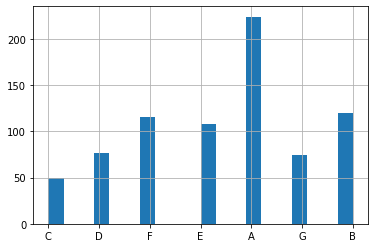

In [7]:
data["Energy.efficiency"].hist(bins=20)
plt.show()

### I.3. Etude multidimensionelle

In [8]:
data.describe()

,Relative.compactness,Surface.area,Wall.area,Roof.area,Overall.height,Glazing.area,Glazing.area.distr,Energy
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.00000,768.000000
mean,0.764511,671.349569,318.331811,176.508879,5.25000,0.234347,2.81250,46.923575
std,0.105914,88.216217,43.942031,45.206368,1.75114,0.133144,1.55096,19.863003
min,0.612496,501.450033,234.338121,105.338876,3.50000,-0.024009,0.00000,10.211493
25%,0.677856,598.684672,291.800051,137.385287,3.50000,0.103055,1.75000,29.360416
50%,0.751687,673.069405,315.761457,183.308441,5.25000,0.247521,3.00000,41.761247
75%,0.835044,744.594128,342.981089,220.510532,7.00000,0.391185,4.00000,64.327196
max,0.991210,825.950839,425.805165,225.757721,7.00000,0.427021,5.00000,94.842601


In [9]:
pd.crosstab(data["Energy.efficiency"],data["orientation"])

orientation,East,North,South,West
Energy.efficiency,,,,
A,56,56,56,56
B,30,30,30,30
C,13,12,13,12
D,19,19,20,19
E,28,27,26,27
F,28,29,30,28
G,18,19,17,20


L'orientation ne joue pas sur l'Energie, on remarque que la répartition des classes est équilibrée. L'orientation ne va pas jouer sur l'énergie. (??)

In [10]:
pd.crosstab(data["Energy.efficiency"],data["Glazing.area.distr"])

Glazing.area.distr,0,1,2,3,4,5
Energy.efficiency,,,,,,
A,24,36,39,43,38,44
B,0,28,25,21,26,20
C,10,8,8,8,8,8
D,10,11,14,14,14,14
E,2,23,20,21,21,21
F,2,22,23,23,22,23
G,0,16,15,14,15,14


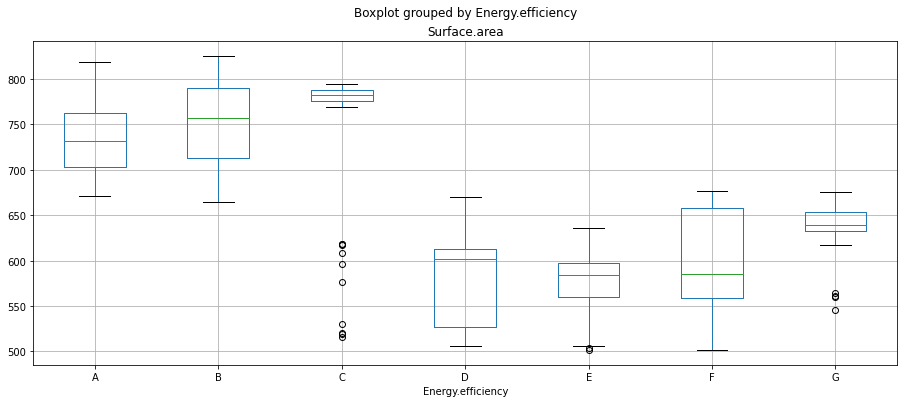

In [11]:
data.boxplot(column = 'Surface.area', by = 'Energy.efficiency', figsize=(15,6))
plt.show()

Les boxplot ne sont pas aligné, on peut dire que la surface va influencer l'Energie 

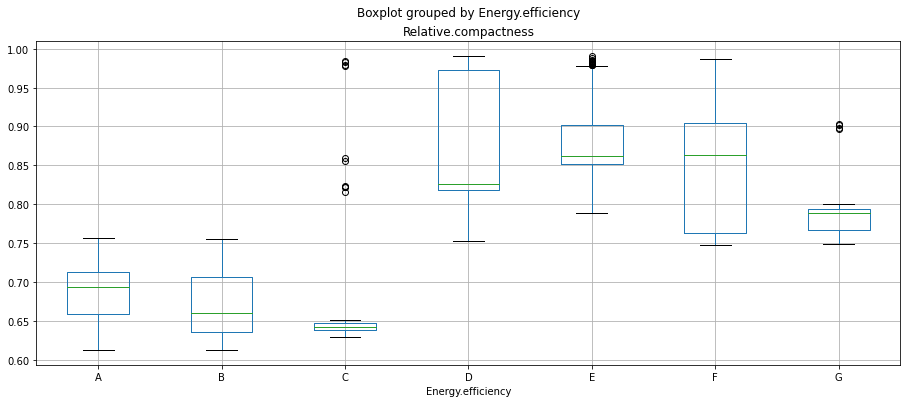

In [12]:
data.boxplot(column = 'Relative.compactness', by = 'Energy.efficiency', figsize=(15,6))
plt.show()

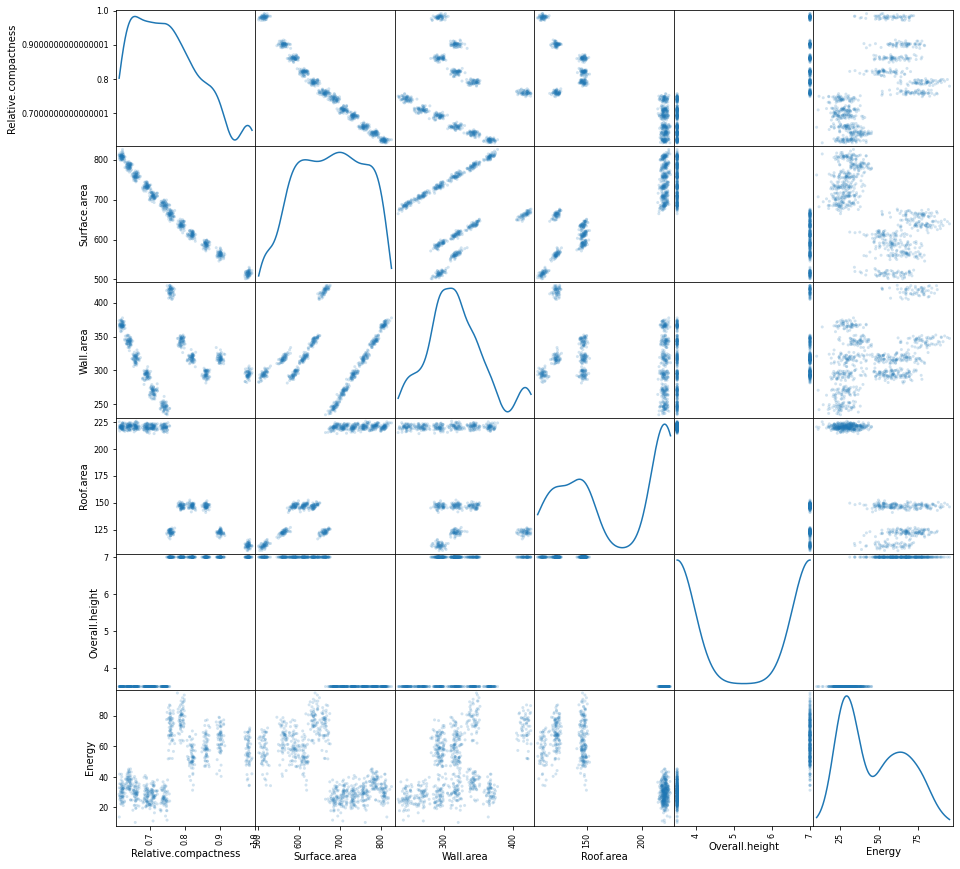

In [13]:
# scatter plot matrix des variables quantitatives
from pandas.plotting import scatter_matrix
data_quantitatives = data[["Relative.compactness","Surface.area","Wall.area","Roof.area","Overall.height","Energy"]]
scatter_matrix(data_quantitatives, alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

On peut prédire l'énergie à partir d'une valeur de relative compactness ou surface area (les deux voites en bas à gauche). 

In [14]:
data_quantitatives.corr()

,Relative.compactness,Surface.area,Wall.area,Roof.area,Overall.height,Energy
Relative.compactness,1.000000,-0.988152,-0.201226,-0.866346,0.824763,0.614011
Surface.area,-0.988152,1.000000,0.198450,0.879256,-0.854655,-0.650053
Wall.area,-0.201226,0.198450,1.000000,-0.292388,0.283634,0.438536
Roof.area,-0.866346,0.879256,-0.292388,1.000000,-0.971743,-0.847396
Overall.height,0.824763,-0.854655,0.283634,-0.971743,1.000000,0.878189
Energy,0.614011,-0.650053,0.438536,-0.847396,0.878189,1.000000


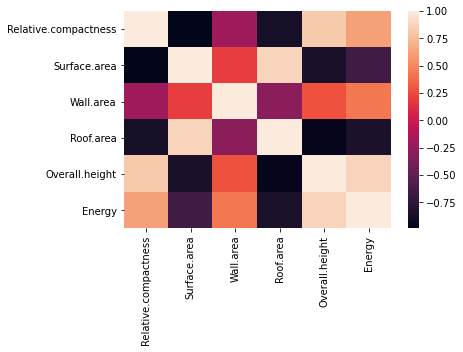

In [15]:
sns.heatmap(data_quantitatives.corr())

### I.4. Analyse des Composantes Principales 

In [16]:
### Libraries 
from sklearn.decomposition import PCA
import sklearn.preprocessing as sp

In [17]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(sp.scale(data_quantitatives))
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, data['Energy.efficiency']], axis = 1)

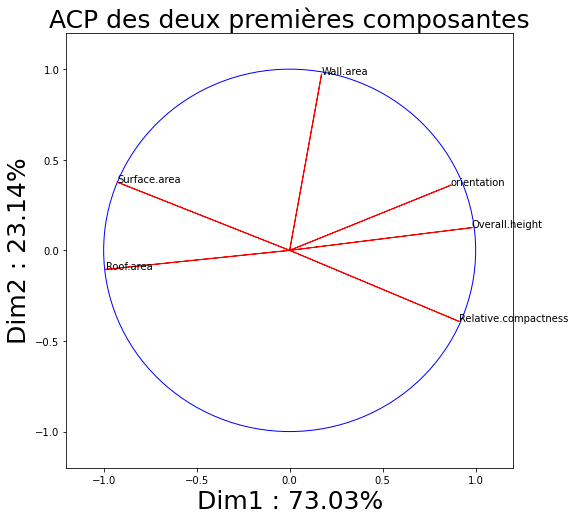

In [18]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, data.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
ax.set_xlabel("Dim1 : " + str(round(pca.explained_variance_ratio_[:10][0]*100,2))+ "%" ,size=25)
ax.set_ylabel("Dim2 : " + str(round(pca.explained_variance_ratio_[:10][1]*100,2)) + "%",size=25)
ax.set_title("ACP des deux premières composantes",size=25)
plt.show()

Commentaire : 
Le graphe représente l'analyse des deux premières composantes principales. Avant de réaliser notre ACP, nous avons réduits nos données à la même échelle afin de pouvoir les placer sur le cercle des corrélations. Plus la variable se rapproche du cercle plus elle est bien représentée dans le plan factoriel et permet donc d'expliquer les composantes principales. 

Le premier axe représente surface area, roof area, l'energie et Overall height. 

Le second axe représente le wall area et relative compactness. 

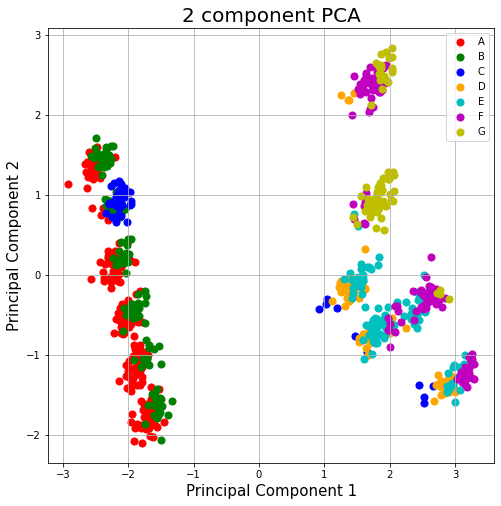

In [19]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = np.unique(data['Energy.efficiency'])
colors = ['r', 'g', 'b', 'orange','c','m','y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Energy.efficiency'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


Commentaire : 
On voit que l'ACP permet déjà de séparer en deux classes les énergies. On peut facilement séparer les A, B de D, F, G et H. La classe C se retrouve dans les deux groupements. 
On peut donc séparer grâce à l'ACP un bon comportement énergétique d'un mauvais, mais il est plus difficile d'aller dans le détails et en subtilité afin de bien classifier sur les 7 classes. 

### I.5 Classification Ascendante Hiérarchique

In [20]:
#Lecture des données sous la forme de matrices de distances 
data_x = data[['Relative.compactness','Surface.area','Wall.area','Roof.area','Overall.height','Glazing.area','Glazing.area.distr','Energy']]

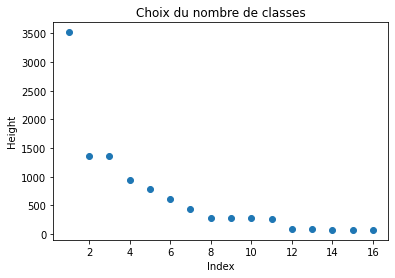

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(data_x, 'ward', metric = 'euclidean') # choix de la distance
height = Z[:, 2]  # Décroissance des sauts
x = np.arange(16) + 1
height = sorted(height, reverse = True)
plt.scatter(x, height[0:16])  #height[0:16]/sum(height[0:16])*100
plt.xlabel('Index')
plt.ylabel('Height')
plt.title("Choix du nombre de classes")
plt.show()

Quel nombre de classe à retenir ?
Pour nous aider, nous avons représenter les sauts d'internies du dendograme selon le nombre de classe retenus. 
Comme on peut le voir ci dessus, nous avons 2 sauts majeurs (celui de 1 à 2 groupes et celui de 3 à 4 groupes) 
Nous pouvons donc retenir 4 groupes.  

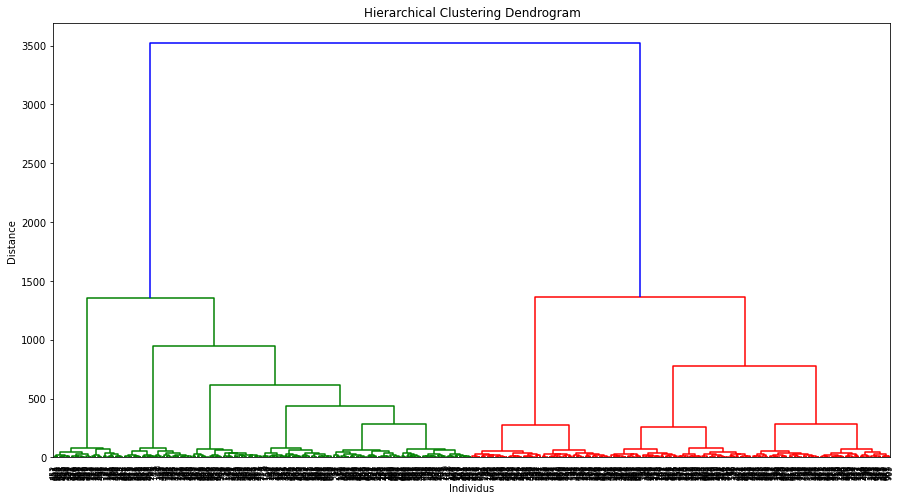

In [22]:
plt.figure(figsize = (15, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Individus')
plt.ylabel('Distance')
dendrogram(Z,leaf_font_size = 8.)
plt.show()

Nous coupons donc l'arbre à une distance comprise entre 1000 et 1400. 

In [121]:
## Tableau de résultats pour les parties II et III
Results = pd.DataFrame(index = ["Accuracy"], columns = ["C_LR_sans_pénalité", "C_LR_Lasso", "C_LR_Ridge", "C_LR_EN", "C_Boosting", "C_OT", "C_RF", "C_SVM", "R_LR_sans_pénalité", "R_LR_Lasso", "R_LR_Ridge", "R_LR_EN", "R_Boosting", "R_OT", "R_RF", "R_SVR"])

## II. Model : Classification 

In [220]:
### Processing sur le colonne orientation 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['orientation']=le.fit_transform(data['orientation'])

In [221]:
### Train, Test split
from sklearn.model_selection import train_test_split
X = data.iloc[:,0:9]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=109)

Commentaire : 
Lorsqu'on parle de performance d'algorithmes de classification et de regression, il est import de séparer le jeu de donné en données d'entrainement et de tests afin de généraliser nos modéles de prédiction. 

### II.1. Regression Logistique 

#### II.1.1 Regression Logistique sans pénalisation

In [222]:
### Library 
from sklearn.linear_model import LogisticRegression

In [223]:
### Model parameters evalutaion 
# evaluation
param=[{"C":[0.5,1,5,10,12,15,30]}]
logitS = GridSearchCV(LogisticRegression(penalty="none", multi_class='multinomial'), param,cv=5,n_jobs=-1)
logitSP=logitS.fit(X_train, y_train)
# paramètre optimal
logitSP.best_params_["C"]
print("Meilleur score (apprentissage) = %f, Meilleur paramètre = %s" %
      (1.-logitSP.best_score_,logitSP.best_params_))

Meilleur score (apprentissage) = 0.344462, Meilleur paramètre = {'C': 0.5}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [224]:
### Model 
# Prediction 
y_chap = logitSP.predict(X_test)

In [226]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_chap,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
Results['C_LR_sans_pénalité']['Accuracy'] = acc
print("Accuracy:",acc)

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,58,21,3,0,0,0,0
B,4,16,14,0,0,0,0
C,0,2,0,0,0,0,0
D,0,0,3,9,3,1,0
E,0,0,0,5,23,10,3
F,0,0,0,1,8,20,7
G,0,0,0,0,0,8,12


Accuracy: 0.5974025974025974


#### II.1.2 Regression Logistique avec pénalisation

##### Pénalisation LASSO

In [127]:
### Model parameters evalutaion 
# evaluation
param=[{"C":[0.5,1,5,10,12,15,30]}]
logitL = GridSearchCV(LogisticRegression(penalty="l1", multi_class='multinomial', solver='saga'), param,cv=5,n_jobs=-1)
# Choix du solver='saga' car compatilité avec la pénalisation l1 et 'multinomial'
logitLasso=logitL.fit(X_train, y_train)
# Sélection du paramètre optimal
logitLasso.best_params_["C"]
print("Meilleur score (apprentissage) = %f, Meilleur paramètre = %s" %
      (1.-logitLasso.best_score_,logitLasso.best_params_))

Meilleur score (apprentissage) = 0.430183, Meilleur paramètre = {'C': 10}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [128]:
### Model 
# Prediction 
y_chap = logitLasso.predict(X_test)

In [129]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_chap,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
Results['C_LR_Lasso']['Accuracy'] = acc
print("Accuracy:",acc)

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,62,31,6,0,0,0,0
B,0,8,11,0,0,0,0
D,0,0,3,10,2,0,0
E,0,0,0,2,22,8,7
F,0,0,0,3,10,24,2
G,0,0,0,0,0,7,13


Accuracy: 0.6017316017316018


##### Pénalisation RIDGE

In [130]:
### Model parameters evalutaion 
# evaluation
param=[{"C":[0.5,1,5,10,12,15,30]}]
logitR = GridSearchCV(LogisticRegression(penalty="l2", multi_class='multinomial'), param,cv=5,n_jobs=-1)
logitRidge=logitR.fit(X_train, y_train)
# Sélection du paramètre optimal
logitRidge.best_params_["C"]
print("Meilleur score (apprentissage) = %f, Meilleur paramètre = %s" %
      (1.-logitRidge.best_score_,logitRidge.best_params_))

Meilleur score (apprentissage) = 0.327657, Meilleur paramètre = {'C': 1}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [131]:
### Model 
# Prediction 
yChap = logitRidge.predict(X_test)

In [133]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_chap,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
Results['C_LR_Ridge']['Accuracy'] = acc
print("Accuracy:",acc)

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,62,31,6,0,0,0,0
B,0,8,11,0,0,0,0
D,0,0,3,10,2,0,0
E,0,0,0,2,22,8,7
F,0,0,0,3,10,24,2
G,0,0,0,0,0,7,13


Accuracy: 0.6017316017316018


###### Pénalisation ElasticNet

In [134]:
### Model parameters evalutaion 
# evaluation
param=[{"C":[0.5,1,5,10,12,15,30]}]
logitE = GridSearchCV(LogisticRegression(penalty="elasticnet", multi_class='multinomial', solver='saga', l1_ratio=0.5), param,cv=5,n_jobs=-1)
logitEN=logitE.fit(X_train, y_train)
# Sélection du paramètre optimal
logitRidge.best_params_["C"]
print("Meilleur score (apprentissage) = %f, Meilleur paramètre = %s" %
      (1.-logitEN.best_score_,logitEN.best_params_))

Meilleur score (apprentissage) = 0.430183, Meilleur paramètre = {'C': 5}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [108]:
### Model 
# Prediction 
yChap = logitEN.predict(X_test)

In [135]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_chap,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
Results['C_LR_EN']['Accuracy'] = acc
print("Accuracy:",acc)

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,62,31,6,0,0,0,0
B,0,8,11,0,0,0,0
D,0,0,3,10,2,0,0
E,0,0,0,2,22,8,7
F,0,0,0,3,10,24,2
G,0,0,0,0,0,7,13


Accuracy: 0.6017316017316018


### II.2. Arbres binaires de décision 

#### II.2.1. Optimal tree 

In [38]:
### Library 
from sklearn.tree import DecisionTreeClassifier

In [116]:
### Model parameters evalutaion 
# evaluation
tps0=time.perf_counter()
# Optimisation de la profondeur de l'arbre
param=[{"max_depth":list(range(2,500))}]
tree= GridSearchCV(DecisionTreeClassifier(),param,cv=10,n_jobs=-1)
treeOpt=tree.fit(X_train, y_train)
# paramètre optimal
tps1=(time.perf_counter()-tps0)
print("Temps arbre = %f, Meilleur taux = %f, Meilleur paramètre = %s" % (tps1, 1. - treeOpt.best_score_,treeOpt.best_params_))

Temps arbre = 24.748754, Meilleur taux = 0.176869, Meilleur paramètre = {'max_depth': 170}


In [117]:
### Model 
# Prediction 
y_chap = treeOpt.predict(X_test)

In [137]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_chap,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
Results['C_OT']['Accuracy'] = acc
print("Accuracy:",acc)

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,62,31,6,0,0,0,0
B,0,8,11,0,0,0,0
D,0,0,3,10,2,0,0
E,0,0,0,2,22,8,7
F,0,0,0,3,10,24,2
G,0,0,0,0,0,7,13


Accuracy: 0.6017316017316018


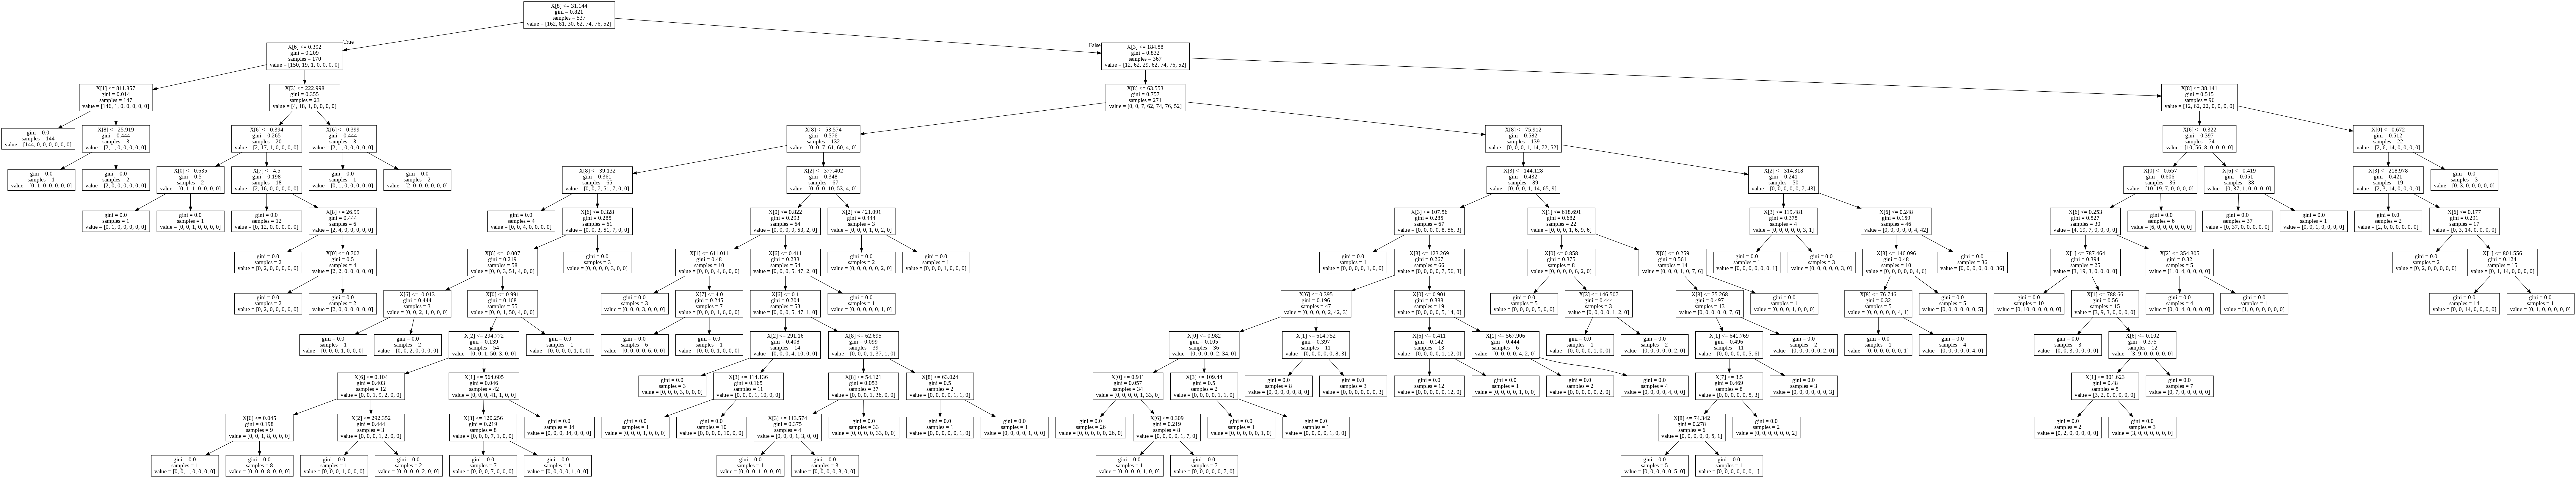

In [138]:
### Affichage de l'arbre de décision 
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
import pydotplus
from IPython.display import Image
treeG=DecisionTreeClassifier(max_depth=33)
treeG.fit(X_train,y_train)
dot_data = StringIO() 
export_graphviz(treeG, out_file=dot_data) 
graph=pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png("treeOpt.png")  
Image(filename='treeOpt.png')

#### II.2.2. Random Forest

In [140]:
# Library
from sklearn.ensemble import RandomForestClassifier 

In [141]:
### Model parameters evalutaion 
# evaluation
tps0=time.perf_counter()
param=[{"max_features": list(range(5, 13))}]
rf= GridSearchCV(RandomForestClassifier(n_estimators=100),param,cv=10,n_jobs=-1)
rfOpt=rf.fit(X_train, y_train)
# paramètre optimal
tps1=(time.perf_counter()-tps0)
print("Temps r forest = %f, Meilleur taux = %f, Meilleur paramètre = %s" % (tps1,1. - rfOpt.best_score_, rfOpt.best_params_))

Temps r forest = 11.663581, Meilleur taux = 0.139553, Meilleur paramètre = {'max_features': 5}


In [142]:
### Model 
# Prediction 
y_chap = rfOpt.predict(X_test)

In [145]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_chap,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
Results['C_RF']['Accuracy'] = acc
print("Accuracy:",acc)

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,61,3,0,0,0,0,0
B,1,36,4,0,0,0,0
C,0,0,16,0,0,0,0
D,0,0,0,13,3,0,0
E,0,0,0,2,29,5,0
F,0,0,0,0,2,30,3
G,0,0,0,0,0,4,19


Accuracy: 0.8831168831168831


Energy 0.4519541879334021
Glazing.area 0.1702756533517678
Relative.compactness 0.08843173119783707
Roof.area 0.08839404731221667
Surface.area 0.0873349685093992
Wall.area 0.05775658489573585
Overall.height 0.037490368858095834
Glazing.area.distr 0.011521994526092452


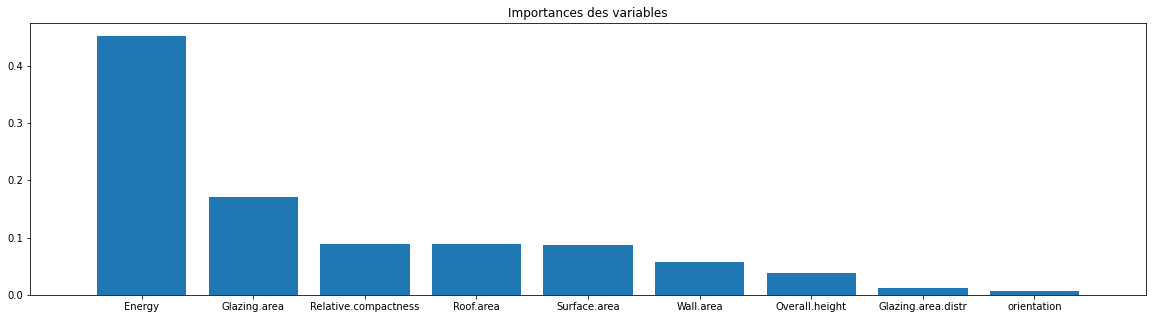

In [146]:
rf= RandomForestClassifier(n_estimators = 100, max_features = 6  )
rfOpt=rf.fit(X_train, y_train)
# Importance décroissante des variables
importances = rfOpt.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(8):
    print(X_train.columns[indices[f]], importances[indices[f]])
# Graphe des importances
plt.figure(1, figsize=(20, 5))
plt.title("Importances des variables")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]),X_train.columns[indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

### II.3 Boosting 

In [49]:
### Library
from sklearn.ensemble import GradientBoostingClassifier

In [50]:
### Model parameters evalutaion 
# evaluation
paramGrid = [{'n_estimators': list(range(100,601,50)), 'learning_rate': [0.1,0.2,0.3,0.4]}]
gbmC= GridSearchCV(GradientBoostingClassifier(),paramGrid,cv=5,n_jobs=-1)
gbmOpt=gbmC.fit(X_train, y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - gbmOpt.best_score_,gbmOpt.best_params_))

Meilleur score = 0.154552, Meilleur paramètre = {'learning_rate': 0.2, 'n_estimators': 250}


In [148]:
### Model training and predict 
# Predict 
y_pred = gbmOpt.predict(X_test)

In [150]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
Results['C_Boosting']['Accuracy'] = acc
print("Accuracy:",acc)

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,61,3,0,0,0,0,0
B,1,36,3,0,0,0,0
C,0,0,16,0,0,0,0
D,0,0,1,13,5,0,0
E,0,0,0,2,25,7,0
F,0,0,0,0,4,30,3
G,0,0,0,0,0,2,19


Accuracy: 0.8831168831168831


### II.4 Super Vector Machine 

In [151]:
### Library
from sklearn.svm import SVC

In [152]:
### Model parameters evalutaion 
# evaluation
param=[{"C":[0.4,0.5,0.6,0.8,1,1.4,2,6,10,20,50,100,1000,2000]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(X_train, y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.232739, Meilleur paramètre = {'C': 1000}


In [153]:
### Model training and predict 
# Train
clf = SVC(C=1000, kernel='linear') #kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
clf.fit(X_train, y_train)
# Predict 
y_pred = clf.predict(X_test)

In [154]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
Results['C_SVM']['Accuracy'] = acc
print("Accuracy:",acc)

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,58,7,0,0,0,0,0
B,4,29,9,0,0,0,0
C,0,3,10,0,1,0,0
D,0,0,1,13,4,0,0
E,0,0,0,2,23,11,1
F,0,0,0,0,6,25,3
G,0,0,0,0,0,3,18


Accuracy: 0.8831168831168831


Nous avons essayé différents kernels pour le paramètre optimisé C=0.6. Voici les accuracy obtenues pour chaque :  
- rbf --> 0.48  
- poly --> 0.44  
- sigmoid --> 0,268  
- Linear --> 0.76  


## III. Model : Regression + Thresholding

In [155]:
y_reg = data.iloc[:,8] # dataframe contenant la colonne 'energy efficiency'
X_reg = data.iloc[:,0:8] #dataframe contenant les features
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg,test_size=0.3,random_state=109)

In [156]:
y_category = data.iloc[:,9]
y_test_category=y_category.iloc[y_test.index-1] #récupérer la colonne 'energy' level des memes indexes que reg_y_test

### III.1. Regression Logistique 

In [208]:
### Library
from sklearn import linear_model

#### III.1.1 Regression Logistique sans pénalisation

In [211]:
### Model 
LinearModel=linear_model.LinearRegression().fit(X_train, y_train)

In [212]:
# Predict 
y_pred = LinearModel.predict(X_test)

In [214]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
Results['R_LR_sans_pénalité']['Accuracy'] = acc
print("Accuracy:",acc)
# MSE & R2 
print("MSE=",mean_squared_error(y_pred,y_test))
print("R2=",r2_score(y_test,y_pred))

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,48,7,0,0,0,1,0
B,10,17,5,0,0,0,0
C,2,19,9,0,0,0,0
D,2,0,2,5,0,0,0
E,2,1,2,9,19,10,3
F,0,0,0,2,12,22,20
G,0,0,0,0,0,0,2


Accuracy: 0.5281385281385281
MSE= 48.08094967031294
R2= 0.8811048380540333


#### III.1.2 Regression Logistique avec pénalisation

##### Pénalisation LASSO

In [191]:
### Model parameters evalutaion 
# evaluation
param=[{"alpha":[0.05,0.1,0.2,0.3,0.4,0.5,1]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(X_train, y_train)
# paramètre optimal
regLassOpt.best_params_["alpha"]

0.05

In [195]:
# Predict 
y_pred = regLassOpt.predict(X_test)

In [197]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
Results['R_LR_Lasso']['Accuracy'] = acc
print("Accuracy:",acc)
# MSE & R2 
print("MSE=",mean_squared_error(y_pred,y_test))
print("R2=",r2_score(y_test,y_pred))

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,47,6,0,0,0,1,0
B,11,19,4,0,0,0,0
C,2,18,10,0,0,0,0
D,1,0,2,2,0,0,0
E,3,0,2,14,19,7,3
F,0,1,0,0,12,25,20
G,0,0,0,0,0,0,2


Accuracy: 0.5367965367965368
MSE= 50.16424018297732
R2= 0.8759532517275954


##### Pénalisation Ridge

In [201]:
### Model parameters evalutaion 
# evaluation
param=[{"alpha":[0.05,0.1,0.2,0.3,0.4,0.5,1]}]
regRidge = GridSearchCV(linear_model.Ridge(), param,cv=5,n_jobs=-1)
regRidgeOpt=regRidge.fit(X_train,y_train)
# paramètre optimal
regRidgeOpt.best_params_["alpha"]

0.05

In [202]:
### Model training and predict 
# Predict 
y_pred = regRidgeOpt.predict(X_test)

In [203]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
Results['R_LR_Ridge']['Accuracy'] = acc
print("Accuracy:",acc)
# MSE & R2 
print("MSE=",mean_squared_error(y_pred,y_test))
print("R2=",r2_score(y_test,y_pred))

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,49,6,0,0,0,1,0
B,8,20,5,0,0,0,0
C,3,17,9,0,0,0,0
D,2,0,2,5,0,0,0
E,2,1,2,9,19,9,3
F,0,0,0,2,12,23,20
G,0,0,0,0,0,0,2


Accuracy: 0.5497835497835498
MSE= 48.113126562364414
R2= 0.8810252706407935


##### Pénalisation ElasticNet

In [205]:
### Model parameters evalutaion 
# evaluation
param=[{"alpha":[0.05,0.1,0.2,0.3,0.4,0.5,1]}]
regElasticNet = GridSearchCV(linear_model.ElasticNet(), param,cv=5,n_jobs=-1)
regElasticNetOpt=regElasticNet.fit(X_train, y_train)
# paramètre optimal
regElasticNetOpt.best_params_["alpha"]

0.05

In [206]:
### Model training and predict 
# Predict 
y_pred = regElasticNetOpt.predict(X_test)

In [207]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
Results['R_LR_EN']['Accuracy'] = acc
print("Accuracy:",acc)
# MSE & R2 
print("MSE=",mean_squared_error(y_pred,y_test))
print("R2=",r2_score(y_test,y_pred))

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,45,15,0,0,0,1,0
B,12,17,6,0,0,0,0
C,3,11,8,0,0,0,0
E,4,1,4,16,27,19,8
F,0,0,0,0,4,13,16
G,0,0,0,0,0,0,1


Accuracy: 0.4805194805194805
MSE= 61.405393454636744
R2= 0.84815599007079


### III.2. Arbres binaires de décision 

#### III.2.1. Optimal tree 

In [157]:
### Library 
from sklearn.tree import DecisionTreeRegressor

In [158]:
### Model parameters evalutaion 
# evaluation
param=[{"max_depth":list(range(2,10))}]
tree= GridSearchCV(DecisionTreeRegressor(),param,cv=10,n_jobs=-1)
treeOpt=tree.fit(X_train, y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))

Meilleur score = 0.081681, Meilleur paramètre = {'max_depth': 5}


In [163]:
### Model training and predict 
# Predict
y_pred = treeOpt.predict(X_test)

In [165]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
Results['R_OT']['Accuracy'] = acc
print("Accuracy:",acc)

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,47,8,1,0,0,1,0
B,10,26,3,0,0,0,0
C,3,9,13,0,0,0,0
D,2,0,0,15,14,5,0
E,2,0,0,0,10,5,0
F,0,1,0,1,6,20,7
G,0,0,1,0,1,2,18


Accuracy: 0.645021645021645


#### III.2.2. Random Forest

In [166]:
### Library 
from sklearn.ensemble import RandomForestRegressor

In [167]:
### Model parameters evalutaion 
# evaluation
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestRegressor(n_estimators=100),param,cv=5,n_jobs=-1)
rfOpt=rf.fit(X_train, y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.055618, Meilleur paramètre = {'max_features': 5}


In [168]:
### Model training and predict 
# Predict
y_pred = rfOpt.predict(X_test)

In [169]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
Results['R_RF']['Accuracy'] = acc
print("Accuracy:",acc)

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,48,3,0,0,0,1,0
B,9,35,2,0,0,0,0
C,3,5,15,0,0,0,0
D,2,0,0,11,2,0,0
E,2,0,0,4,22,8,0
F,0,1,1,0,6,23,5
G,0,0,0,1,1,1,20


Accuracy: 0.7532467532467533


### III.3 Boosting 

In [170]:
### Library 
from sklearn.ensemble import GradientBoostingRegressor

In [171]:
### Model parameters evalutaion 
# evaluation
tps0 = time.perf_counter()
param = [{"n_estimators": [50, 100, 150]}]
gbmReg = GridSearchCV(GradientBoostingRegressor(random_state=0), param)
gbmOptReg = gbmReg.fit(X_train, y_train)
# paramètre optimal
tps1 = (time.perf_counter() - tps0)
print("Temps boosting = %f, Meilleur taux = %f, Meilleur paramètre = %s" % (tps1,1. - gbmOptReg.best_score_, gbmOptReg.best_params_))

Temps boosting = 1.705057, Meilleur taux = 0.053441, Meilleur paramètre = {'n_estimators': 150}


In [172]:
### Model training and predict 
# Predict
y_pred = gbmOptReg.predict(X_test)

In [174]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
Results['R_Boosting']['Accuracy'] = acc
print("Accuracy:",acc)

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,51,5,0,0,0,1,0
B,7,33,2,0,0,0,0
C,2,5,15,0,0,0,0
D,2,0,0,9,1,0,0
E,2,0,1,6,21,12,0
F,0,1,0,0,8,19,6
G,0,0,0,1,1,1,19


Accuracy: 0.7229437229437229


### III.4 Super Vector Regression

In [175]:
### Library 
from sklearn.svm import SVR

In [176]:
### Model parameters evalutaion 
# evaluation
param=[{"C":[0.4,0.5,0.6,0.8,1,1.4,2,6,10,20,50,100,1000,2000]}]
svr= GridSearchCV(SVR(kernel = 'linear'),param,cv=10,n_jobs=-1)
svrOpt=svr.fit(X_train, y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svrOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.134819, Meilleur paramètre = {'C': 1000}


In [177]:
### Model training and predict 
# Predict
y_pred = svrOpt.predict(X_test)

In [180]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
Results['R_SVR']['Accuracy'] = acc
print("Accuracy:",acc)

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,48,7,0,0,0,1,0
B,10,18,5,0,0,0,0
C,2,18,9,0,0,0,0
D,0,0,2,0,0,0,0
E,4,0,2,16,20,6,4
F,0,1,0,0,11,26,19
G,0,0,0,0,0,0,2


Accuracy: 0.5324675324675324


## IV. Comparaison et conclusion 

In [181]:
Results

,C_LR_sans_pénalité,C_LR_Lasso,C_LR_Ridge,C_LR_EN,C_Boosting,C_OT,C_RF,C_SVM,R_LR_sans_pénalité,R_LR_Lasso,R_LR_Ridge,R_LR_EN,R_Boosting,R_OT,R_RF,R_SVR
Accuracy,0.766234,0.601732,0.601732,0.601732,0.883117,0.883117,0.883117,0.883117,NaN,NaN,NaN,NaN,0.722944,0.645022,0.753247,0.532468
